In [1]:
%cd ..

/home/cml0/rl-aux


In [2]:
%pwd

'/home/cml0/rl-aux'

In [34]:
import subprocess
from tabnanny import verbose
from datasets.transforms import svhn_trans_train, svhn_trans_test

import torch
from datasets.cifar10 import CIFAR10
from torch import nn
from datasets.cifar10 import CIFAR10
from datasets.svhn import SVHN
from datasets.transforms import cifar_trans_train, cifar_trans_test
from environment.learn_weight_aux_task import AuxTaskEnv
from networks.ppo.ppo import get_ppo_agent
from networks.primary.vgg import VGG16
from train.train_auxilary_agent import train_auxilary_agent
from utils.log import log_print, change_log_location
from utils.path_name import create_path_name, save_all_parameters

from datasets.cifar100 import CIFAR100, CoarseLabelCIFAR100
from datasets.transforms import cifar_trans_train, cifar_trans_test
from environment.learn_weight_aux_task import AuxTaskEnv
from networks.ppo.ppo import get_ppo_agent
from networks.primary.vgg import VGG16
from train.train_auxilary_agent import train_auxilary_agent
from utils.log import log_print, change_log_location
from utils.path_name import create_path_name, save_all_parameters
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix
import numpy as np
BATCH_SIZE = 100
AUX_DIMENSION = 100
PRIMARY_DIMENSION = 20
OBSERVATION_FEATURE_DIMENSION = 256
TOTAL_EPOCH = 200
PRIMARY_LEARNING_RATE = 0.01
PPO_LEARNING_RATE = 0.0003
SCHEDULER_STEP_SIZE = 50
SCHEDULER_GAMMA = 0.5
AUX_WEIGHT = 1
TRAIN_RATIO = 1
LEARN_WEIGHTS = False
DEVICE      = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")


In [54]:
# ./SINGLETASK_VGG_learn_weights_False_train_ratio_1_aux_weight_0_obs_dim_256_SVHN/best_model_primary
# ./PPO_VGG_learn_weights_False_train_ratio_1_aux_weight_1_obs_dim_256_CIFAR100-20v2/best_model_primary
# ./PPO_VGG_learn_weights_False_train_ratio_1_aux_weight_1_obs_dim_256_SVHN/best_model_primary
# ./PPO_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_256_SVHN/best_model_primary
# ./WEIGHT_TUNING_PPO_RESET_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_256_CIFAR100-20/best_model_primary
# ./PPO_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_256_CIFAR10/best_model_primary
# ./PPO_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_256_CIFAR100/best_model_primary
# ./PPO_RESET_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_256_CIFAR100-20/best_model_primary
# ./PPO_POST_AUX_LABEL_SOFTMAX_VGG_learn_weights_False_train_ratio_1_aux_weight_1_obs_dim_256_CIFAR100-20/best_model_primary
# ./PPO_RESET_VGG_learn_weights_False_train_ratio_1_aux_weight_1_obs_dim_256_CIFAR100-20/best_model_primary

MODEL_NAME = "SINGLETASK_VGG_learn_weights_False_train_ratio_1_aux_weight_0_obs_dim_256_SVHN" #P=0.9462  R=0.9460  F1=0.9460
MODEL_NAME = "PPO_VGG_learn_weights_False_train_ratio_1_aux_weight_1_obs_dim_256_SVHN" #P=0.9560  R=0.9558  F1=0.9559
MODEL_NAME = "PPO_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_256_SVHN" #P=0.9632  R=0.9630  F1=0.9631

MODEL_NAME = "PPO_VGG_learn_weights_False_train_ratio_1_aux_weight_1_obs_dim_256_CIFAR100-20v2" # P=0.7619  R=0.7624  F1=0.7618
#MODEL_NAME = "PPO_RESET_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_256_CIFAR100-20" #P=0.8073  R=0.8069  F1=0.8067

vgg16 = VGG16.load(f"/home/cml0/rl-aux/trained_models/{MODEL_NAME}/best_model_primary").to(DEVICE)
print("loaded")

loaded


In [55]:
cifar100_train_set = CIFAR100(root='./data/cifar100', train=True, transform=cifar_trans_train,download=True)
cifar100_test_set = CIFAR100(root='./data/cifar100', train=False, transform=cifar_trans_test,download=True)

course_cifar_train_set = CoarseLabelCIFAR100(cifar100_train_set)
course_cifar_test_set = CoarseLabelCIFAR100(cifar100_test_set)

cifar100_train_loader = torch.utils.data.DataLoader(
    dataset=course_cifar_train_set,
    batch_size=BATCH_SIZE,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    dataset=course_cifar_test_set,
    batch_size=BATCH_SIZE,
    shuffle=True)

svhn_train_set = SVHN(
    root="./data/svhn",
    train=True,
    transform=svhn_trans_train,
)
svhn_test_set = SVHN(
    root="./data/svhn",
    train=False,
    transform=svhn_trans_test)

svhn_dataloader_train = torch.utils.data.DataLoader(
    dataset=svhn_train_set,
    batch_size=BATCH_SIZE,
    shuffle=True
)
svhn_dataloader_test = torch.utils.data.DataLoader(
    dataset=svhn_test_set,
    batch_size=BATCH_SIZE,
    shuffle=True
)
# test_loader = svhn_dataloader_test



Files already downloaded and verified
Files already downloaded and verified


In [56]:
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)

        out = vgg16(images)
        # If your forward returns (primary, aux) keep the first element
        logits = out[0] if isinstance(out, (list, tuple)) else out
        preds  = logits.argmax(dim=1)

        y_true.append(labels.cpu())
        y_pred.append(preds.cpu())

y_true = torch.cat(y_true).numpy()
y_pred = torch.cat(y_pred).numpy()

# ─── 4.  Precision / Recall (per-class & averaged) ────────────────────────────
# labels go from 0-19 for CIFAR100-20 coarse; provide names if you wish
class_names = [f"class_{i}" for i in range(20)]

print("\nPer-class metrics:")
report = classification_report(
    y_true, y_pred,
    target_names=class_names,
    digits=4,            # prettier
    zero_division=0      # avoid warnings if a class was never predicted
)
print(report)

# If you need raw arrays:
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average=None, zero_division=0
)
macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro", zero_division=0
)
micro_p, micro_r, micro_f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="micro", zero_division=0
)

print(f"Macro-avg  P={macro_p:.4f}  R={macro_r:.4f}  F1={macro_f1:.4f}")
print(f"Micro-avg  P={micro_p:.4f}  R={micro_r:.4f}  F1={micro_f1:.4f}")

# (optional) Confusion matrix
cm = confusion_matrix(y_true, y_pred)
np.set_printoptions(linewidth=120)
print("\nConfusion matrix:\n", cm)


Per-class metrics:
              precision    recall  f1-score   support

     class_0     0.6681    0.6080    0.6366       500
     class_1     0.7253    0.7180    0.7216       500
     class_2     0.8602    0.8860    0.8729       500
     class_3     0.7780    0.7640    0.7709       500
     class_4     0.8202    0.8300    0.8250       500
     class_5     0.7465    0.7360    0.7412       500
     class_6     0.8622    0.8260    0.8437       500
     class_7     0.7287    0.7680    0.7478       500
     class_8     0.7046    0.7300    0.7171       500
     class_9     0.8264    0.8760    0.8505       500
    class_10     0.8667    0.8580    0.8623       500
    class_11     0.6988    0.7240    0.7112       500
    class_12     0.7349    0.6820    0.7075       500
    class_13     0.6883    0.6580    0.6728       500
    class_14     0.8507    0.8320    0.8413       500
    class_15     0.5674    0.5980    0.5823       500
    class_16     0.6423    0.6140    0.6278       500
    cla

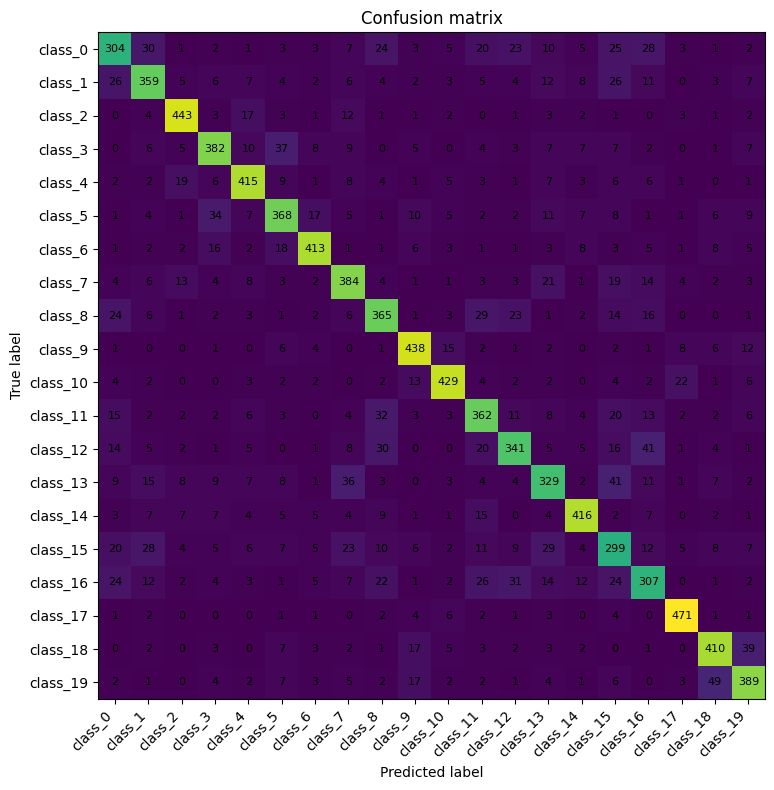

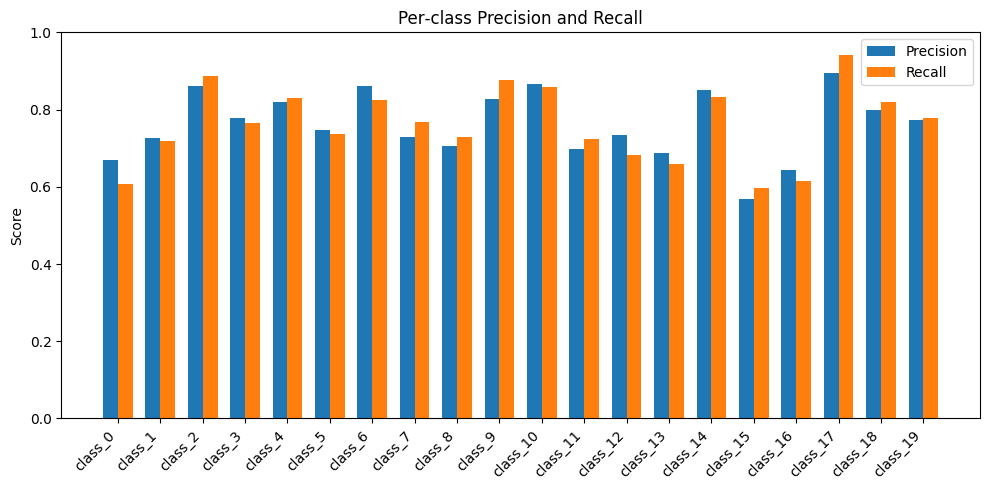

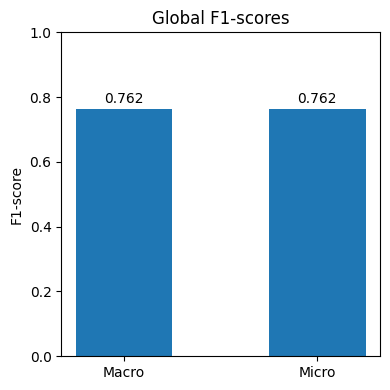

In [57]:
# ─── add near the other imports ────────────────────────────────────────────────
import matplotlib.pyplot as plt
import itertools

# ─── helper #1 : confusion‑matrix heat‑map ─────────────────────────────────────
def plot_confusion_matrix(cm, class_names):
    """
    Pretty confusion matrix with value annotations.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest')        # default colormap
    ax.set_title("Confusion matrix")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    # tick labels
    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(class_names)

    # value annotations
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, f"{cm[i, j]:d}", ha="center", va="center", fontsize=8)

    fig.tight_layout()
    plt.show()


# ─── helper #2 : side‑by‑side precision / recall bars ──────────────────────────
def plot_precision_recall_bar(precision, recall, class_names):
    """
    Bar chart with precision and recall for every class.
    """
    ind   = np.arange(len(class_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(ind,           precision, width, label="Precision")
    ax.bar(ind + width,   recall,    width, label="Recall")

    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_ylim(0, 1)
    ax.set_ylabel("Score")
    ax.set_title("Per‑class Precision and Recall")
    ax.legend()
    fig.tight_layout()
    plt.show()


# ─── after you have cm, precision, recall, macro_* and micro_* ────────────────
plot_confusion_matrix(cm, class_names)
plot_precision_recall_bar(precision, recall, class_names)

# quick overview of global scores
fig, ax = plt.subplots(figsize=(4, 4))
ax.bar(["Macro", "Micro"], [macro_f1, micro_f1], width=0.5)
ax.set_ylim(0, 1)
ax.set_ylabel("F1‑score")
ax.set_title("Global F1‑scores")
for i, v in enumerate([macro_f1, micro_f1]):
    ax.text(i, v + 0.02, f"{v:.3f}", ha="center")
fig.tight_layout()
plt.show()

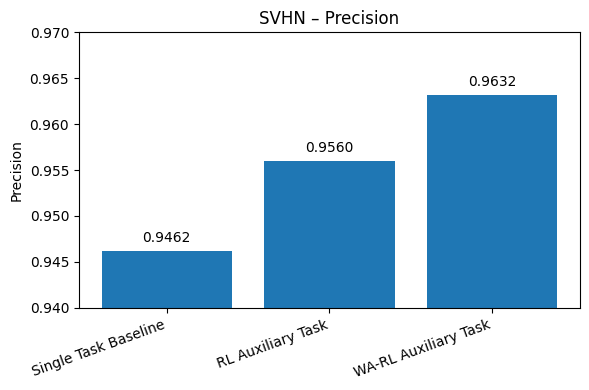

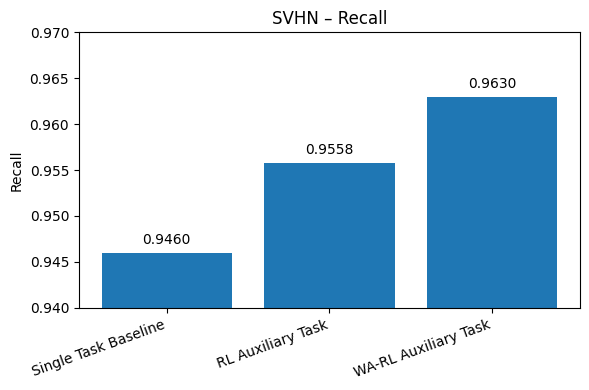

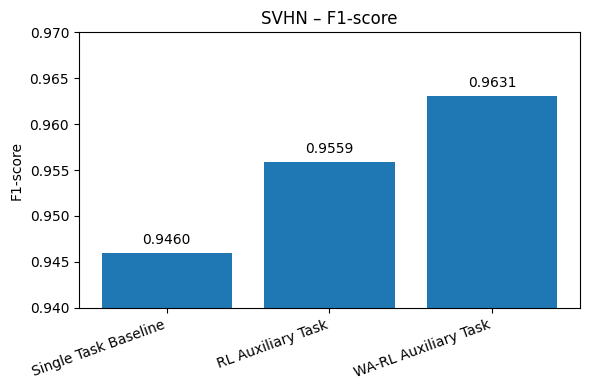

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# ─── Global settings ─────────────────────────────────────────────────────────
FIGSIZE = (6, 4)         # figure size   (width, height) in inches
YLIM    = (0.94, 0.97)   # y-axis window (min, max) for every plot

# ─── Data ────────────────────────────────────────────────────────────────────
models     = ["Single Task Baseline",
              "RL Auxiliary Task",
              "WA-RL Auxiliary Task"]

precision  = [0.9462, 0.9560, 0.9632]
recall     = [0.9460, 0.9558, 0.9630]
f1_scores  = [0.9460, 0.9559, 0.9631]

# ─── Helper for one-metric plot ──────────────────────────────────────────────
def plot_metric(values, metric_name):
    fig, ax = plt.subplots(figsize=FIGSIZE)
    x = np.arange(len(models))

    ax.bar(x, values)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=20, ha="right")
    ax.set_ylim(*YLIM)                 # ← single-place y-axis control
    ax.set_ylabel(metric_name)
    ax.set_title(f"SVHN – {metric_name}")

    # numeric labels above bars
    for i, v in enumerate(values):
        ax.text(i, v + (YLIM[1] - YLIM[0]) * 0.02, f"{v:.4f}",
                ha="center", va="bottom")

    fig.tight_layout()
    plt.show()

# ─── Generate the three figures ──────────────────────────────────────────────
plot_metric(precision, "Precision")
plot_metric(recall,    "Recall")
plot_metric(f1_scores, "F1-score")

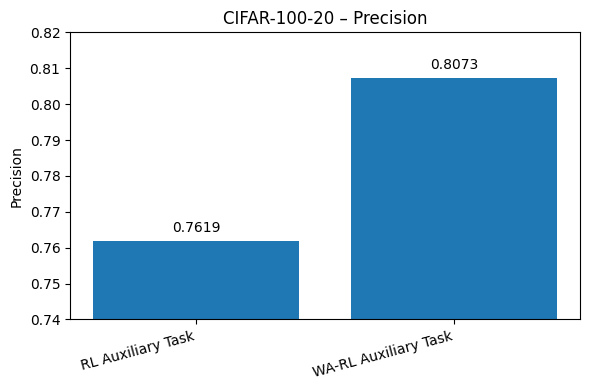

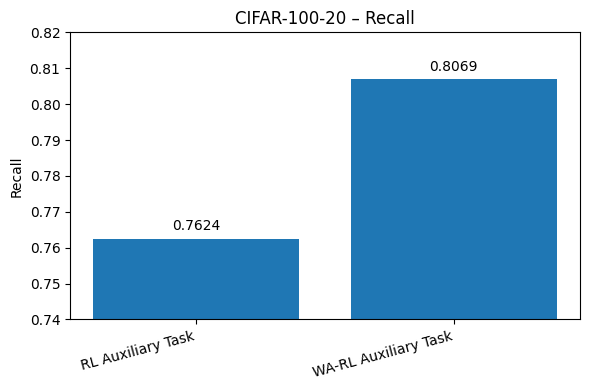

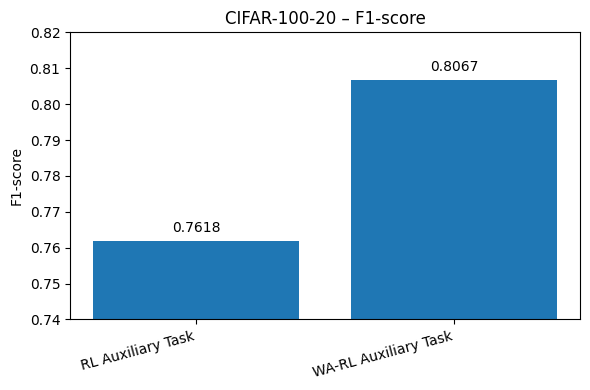

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# ─── Global “window” controls ────────────────────────────────────────────────
FIGSIZE = (6, 4)        # width, height  – change once for every figure
YLIM    = (0.74, 0.82)  # y-axis window – tweak as you like

# ─── CIFAR-100-20 results ────────────────────────────────────────────────────
models     = ["RL Auxiliary Task",
              "WA-RL Auxiliary Task"]

precision  = [0.7619, 0.8073]
recall     = [0.7624, 0.8069]
f1_scores  = [0.7618, 0.8067]

# ─── Helper: one-metric plot ─────────────────────────────────────────────────
def plot_metric(values, metric_name):
    fig, ax = plt.subplots(figsize=FIGSIZE)
    x = np.arange(len(models))

    ax.bar(x, values)                                  # default colours
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=15, ha="right")
    ax.set_ylim(*YLIM)
    ax.set_ylabel(metric_name)
    ax.set_title(f"CIFAR-100-20 – {metric_name}")

    # numeric labels above bars
    for i, v in enumerate(values):
        ax.text(i, v + (YLIM[1] - YLIM[0]) * 0.02,
                f"{v:.4f}", ha="center", va="bottom")

    fig.tight_layout()
    plt.show()

# ─── Generate the three figures ──────────────────────────────────────────────
plot_metric(precision, "Precision")
plot_metric(recall,    "Recall")
plot_metric(f1_scores, "F1-score")